# Оптимизация нейросетей. Дропаут.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/03_seminar_solved.ipynb)



[**Непрорешеный семинар**](https://github.com/m12sl/dl-hse-2021/blob/main/03-training/seminar.ipynb)


# План семинара:

* recap
* Задачи/ф-ии потерь
* Метрики
* Регуляризация
* Добавляем LR Sheduler в трейнер
* LR Sheduler
* WarmUp
* Блиц



# Recap

Нейронная сеть -- просто формула с коэффициентами (весами)

Когда создаем сеть все веса инициализируются случайно.

-----

Наша задача найти веса получше, действуем итеративно:
* считаем частные производные (бекпроп)
* обновляем веса (делаем градиентный спуск)


У нас есть набор операций и слоев из которых можно собрать сеть и представление о предметной области:


# Задачи и ф-ии потерь (по мотивам лекции)
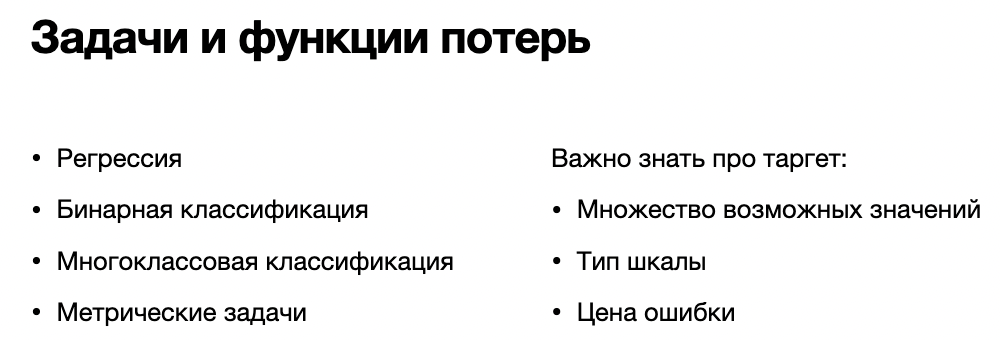

### Делаем регрессию

* Linear(..., N) + **Mean Squared Error** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss))

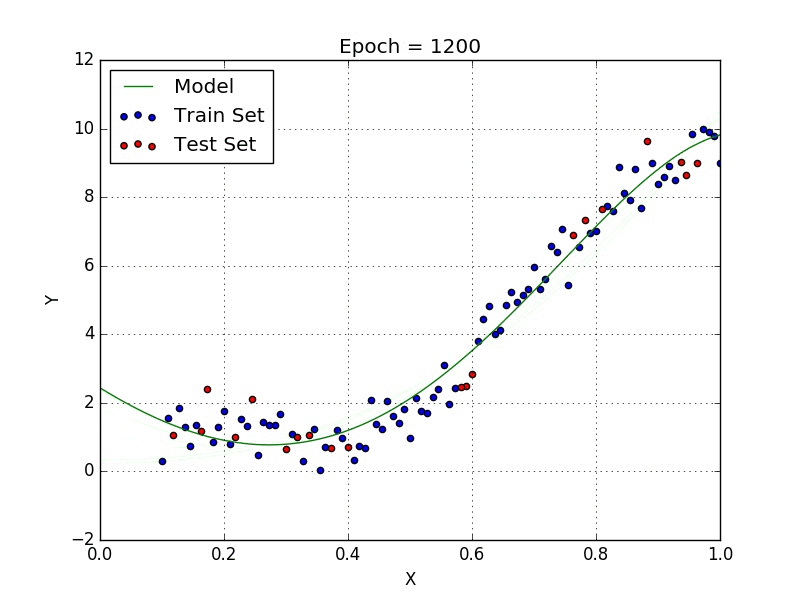

In [1]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.randn(3, 2)

output = loss.forward(input, target)
output

tensor(1.4817, grad_fn=<MseLossBackward0>)


### Делаем классификацию:

**Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


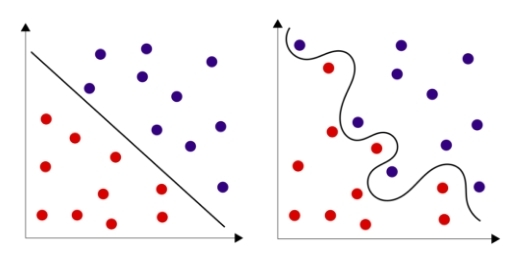

In [2]:
# Example of target with class indices

import torch.nn as nn

loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True) # [ batch_size, class_probability ]

# [ batch_size ] -- метки каждого класса, каждая метка -- это число от [0 до 5)
target = torch.empty(3, dtype=torch.long).random_(5)

output = loss(input, target)
output

tensor(1.7126, grad_fn=<NllLossBackward0>)

### Делаем теггирование:

**Binary Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html))


PS Сори, картинки не нашел, но примером может быть задача тэгорования треков: один трек может именть несколько жанров: `pop`, `rock`, `jazz`, `russian`, `1980s`...

In [3]:
sigmoid = nn.Sigmoid()
loss = nn.BCELoss()

input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(sigmoid(input), target)
output

tensor(0.6386, grad_fn=<BinaryCrossEntropyBackward0>)

# Метрики

TL; DR:
- тренировочные метрики записывать без сглаживания с каждого батча
- валидационные собирать за всю валидацию и рисовать одной точкой


**Особенности TensorBoard**:

- При отображении прореживает точки по global_step, если точек очень много
- Чтобы рисовать на одном графике надо писать в разные папки (завести отдельные train_ и val_writer)
- Хорошей идеей будет создание новой директории с логами для нового эксперимента (можно завязаться, например, на текущую дату+время, чтобы не было коллизий для новых запусков трейнеров)

# Регуляризация

## Dropout

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [4]:
do = nn.Dropout(p=0.5)
do.eval()
print(do.training)

do

False


Dropout(p=0.5, inplace=False)

In [5]:
list(do.parameters())

[]

In [6]:
t = torch.arange(0, 15, dtype=torch.float32).reshape(3, 5)
t

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])

In [7]:
# Sequential( Lin(), DO() ) #  пример использования

In [8]:
# 1 / (1-p)

In [9]:
do(t)

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.do = nn.Dropout()

m = Model()
m.training

True

In [11]:
m = m.eval()
m.do.training

False

## LabelSmoothing

In [12]:
nn.CrossEntropyLoss(label_smoothing=0.1) # но можно и написать свой велосипед

CrossEntropyLoss()

**Несглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 1.0 | 
| Hide The Pain Harold | 0.0 |
| That is fine  | 0.0 |
| Roll Safe Think About It | 0.0 |


**Сглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 0.9 | 
| Hide The Pain Harold | 0.03 |
| That is fine  | 0.03 |
| Roll Safe Think About It | 0.03 |



## WeightDecay

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (..., weight_decay=0.1)

* [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

Stack Overflow: [AdamW and Adam with weight decay](https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay)

В чем разница: 

* Adam + weight_decay --- регуляризация идет через градиенты
```
final_loss = loss + wd * all_weights.pow(2).sum() / 2
```

* AdamW --- регуляризация не идет через лосс
```
w = w - lr * w.grad - lr * wd * w
```


In [15]:
import torch.optim as optim

dummy_module_params = nn.Linear(1, 1).parameters()
adam = optim.Adam(dummy_module_params, weight_decay=0.01)

dummy_module_params = nn.Linear(1, 1).parameters()
adamw = optim.AdamW(dummy_module_params, weight_decay=0.1)

# Обновим Trainer и нашу модель


* Добавим поддержку lr_sheduler
* В модельку добавим дропаут

In [4]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [1]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

# ничего нового, копипаста с предыдущего сема
class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255


        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



In [10]:

# добавили lr_scheduler lr_scheduler_type dropout_p
# добавили post_train_batch post_val_batch post_train_stage post_val_stage
class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None, dropout_p=0.5):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.inner = nn.Sequential(nn.Flatten(),
                                   nn.Linear(784, 10000), # заведомо довольно большая модель, чтобы очевиднее был эффект переобучения и дропаута
                                   nn.Dropout(p=dropout_p),
                                   nn.ReLU(),
                                   nn.Linear(10000, 10))

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

        return


class Trainer:
    def __init__(self, model: nn.Module, optimizer,
                 train_dataset: Dataset, val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/', batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)


    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.post_train_batch()
                for k, v in details.items():
                    self.log_writer.add_scalar(k + "/train", v, global_step=self.global_step)
                self.global_step += 1

            with torch.no_grad():
                model.eval()
                val_losses = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    for k, v in details.items():
                        self.log_writer.add_scalar(k + '/validation', v, global_step=self.global_step)
                    val_losses.append(loss.item())

                val_loss = np.mean(val_losses)
                model.post_val_stage(val_loss)

                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss


## Не забудь поменять Runtime Type в колабе на GPU!

In [25]:
import torch.utils.data

# берем часть исходной обучающей выборки для большей наглядности эффекта применения дропаута
# на большом датасете сложнее переобучиться, поэтому мы искусственно уменьшаем его для наглядности на занятии
# на практике не надо так делать!
fmnist_train_subset = torch.utils.data.Subset(fmnist_train, range(0, len(fmnist_train), 400))

In [27]:
model = VeryModel(dropout_p=0)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val, tboard_log_dir="./tboard_logs_no_dropout")

trainer.train(30)

100%|██████████| 79/79 [00:01<00:00, 78.07it/s]


In [7]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./tboard_logs_no_dropout

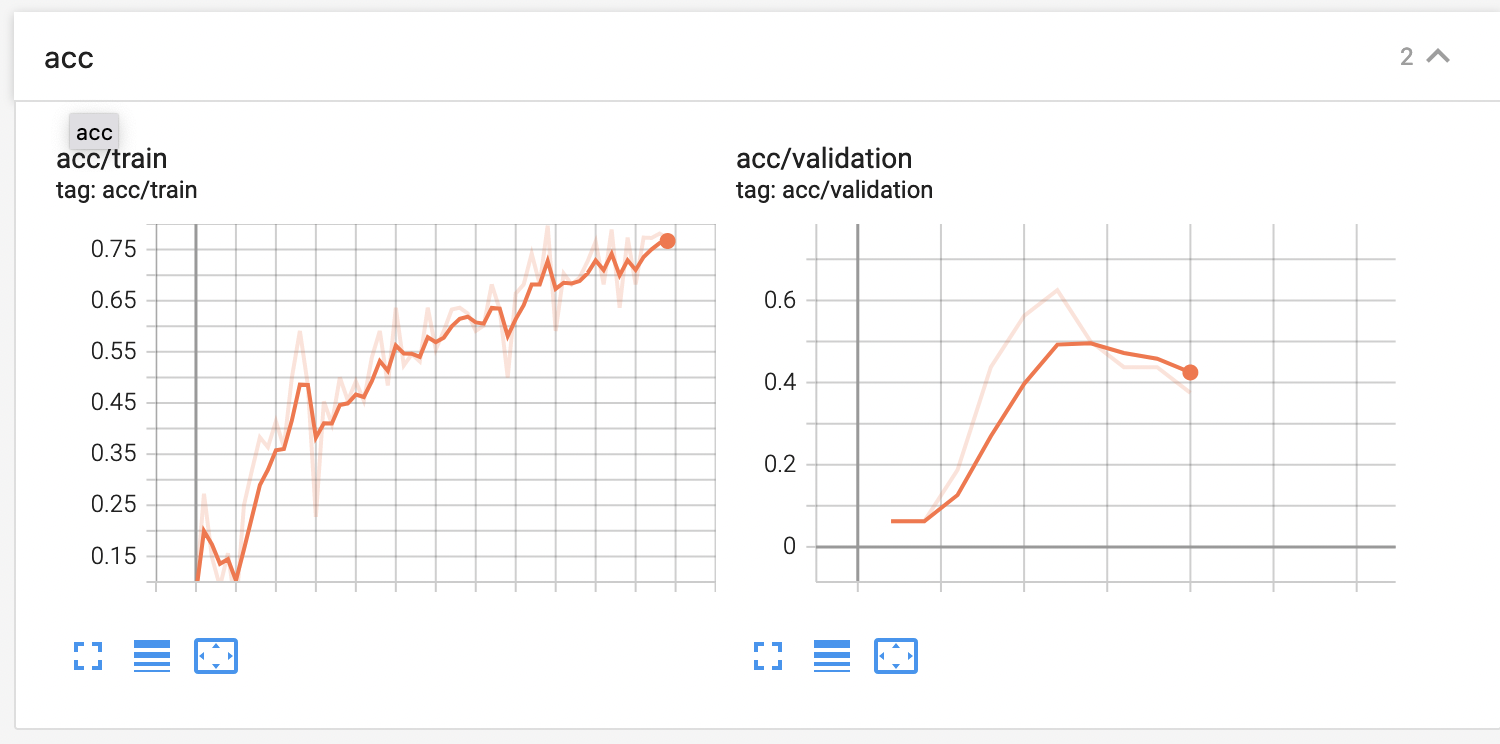

In [29]:
model = VeryModel(dropout_p=0.3)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val, tboard_log_dir="./tboard_logs_with_dropout")

trainer.train(30)

100%|██████████| 79/79 [00:01<00:00, 78.72it/s]


In [ ]:
%tensorboard --logdir ./tboard_logs_with_dropout

Класс! С дропаутом получилось добиться `accuracy~=0.7`. Модель без dropout переобучилась на обучеющей выборке и на вализации для нее получилось, что `accuracy<0.5`


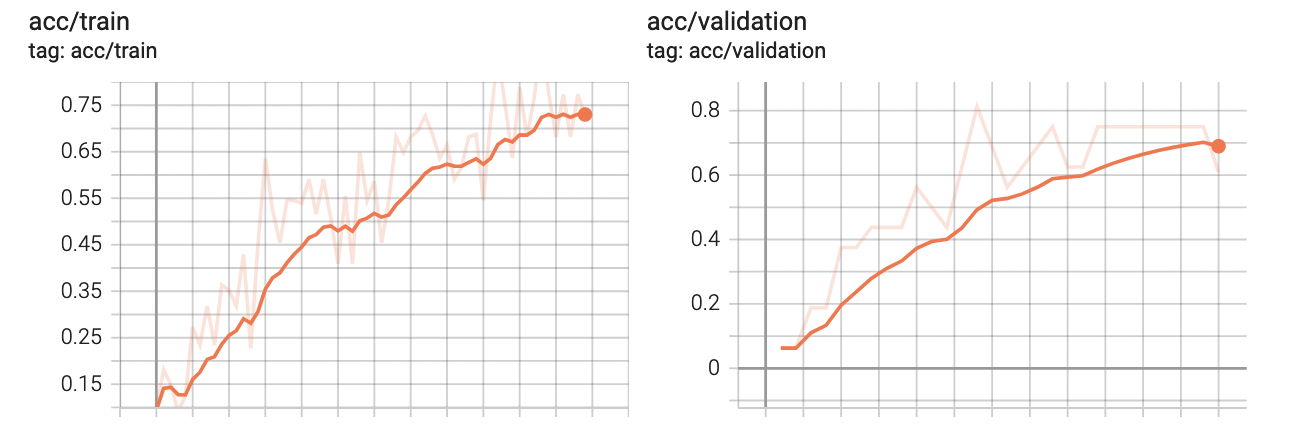

# LR Scheduler

Два типа расписаний:

- по эпохам ([StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), ...) 
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам ([Cyclic](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html), [1cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

In [32]:
def show_scheduler(scheduler, label=None):
    lr_history = []

    if label is None:
        label = str(scheduler)

    for i in range(100):
        lr_history.append(scheduler.get_last_lr()[0])
        scheduler.step()

    plt.plot(lr_history, label=label)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0.5, 1.0, 'StepLR')

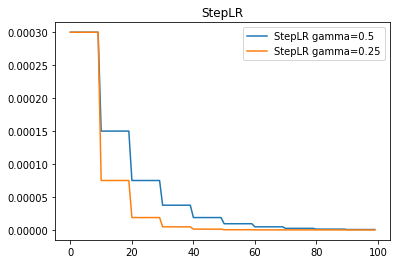

In [33]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5), label="StepLR gamma=0.5" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25), label="StepLR gamma=0.25" )

plt.legend()

plt.title("StepLR")

Text(0.5, 1.0, 'CyclicLR')

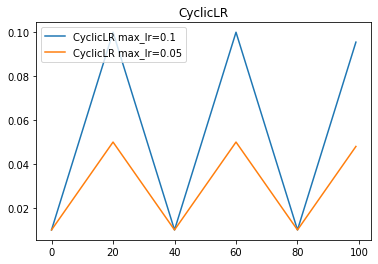

In [34]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.1" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.05" )

plt.legend()

plt.title("CyclicLR")

**Вопрос:** в каких случаях может быть полезен `CyclicLR`? Зачем повышать `lr`?

<!-- если во время оптимизации попали в локальный минимум, с увеличением lr можем выскочить из этого локального минимума и попасть в более глубокую 'лунку' -->

#### Обучим модельку с шедулером

In [35]:
model = VeryModel(lr_scheduler_type='per_batch')
optimizer = Adam(model.parameters(), lr=3e-4)
very_model_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.005, step_size_up=300, cycle_momentum=False)
model.lr_scheduler = very_model_scheduler

trainer = Trainer(model, optimizer, fmnist_train, fmnist_val)
trainer.train(3)


100%|██████████| 79/79 [00:01<00:00, 69.16it/s]


# WarmUp

**Проблема:** очень большие сетки может сильно разнести, если сразу начать их оптимизировать на больших батчах


Чтобы сеть не расходилась сразу, можно постепенно увеличивать lr --- тогда оптимизаторы постепенно накопят статистики по разным группам параметров

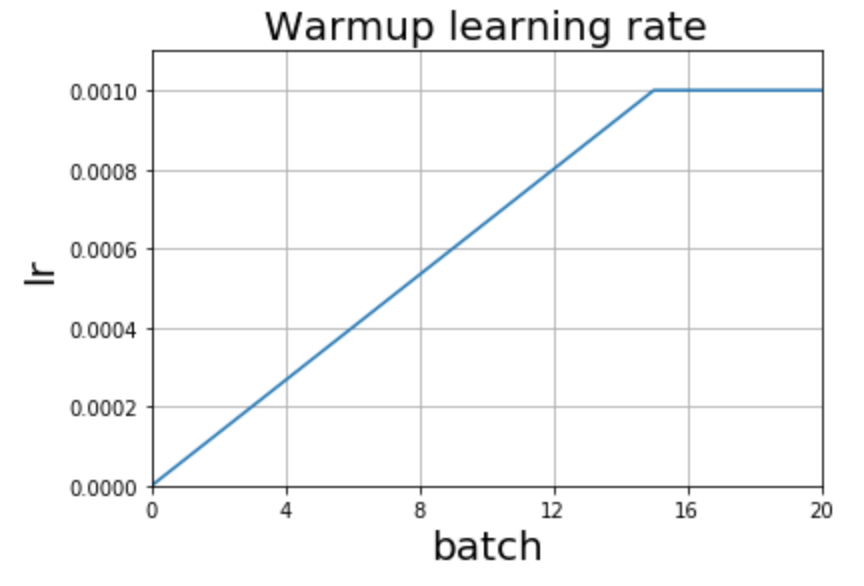


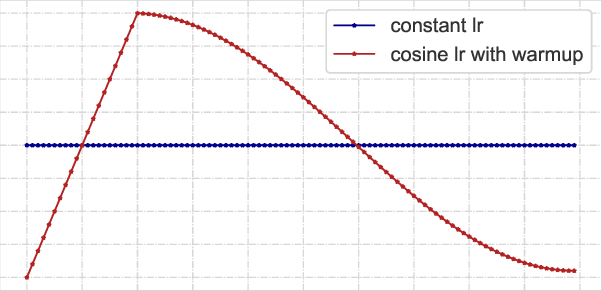

# batch_size / lr ~= const *

Для какой из линий больше `batch_size` на картинке ниже?

(*) Дисклаймер: обычно верно для конкретной задачи, для конкретной модели. Если меняется что-то одно, то это соотношение может меняться

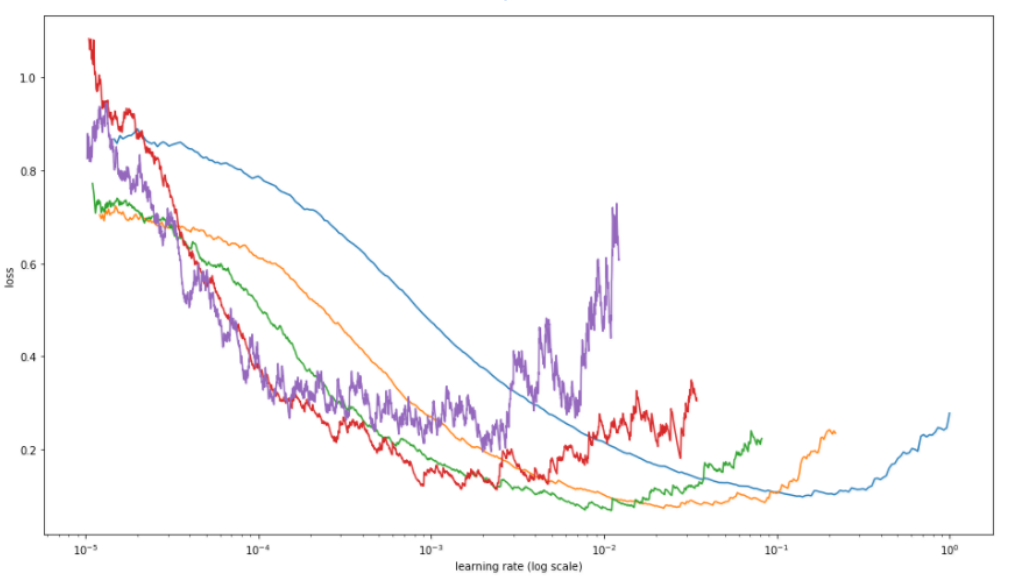

# Блиц по практике обучения нейросетей


### Зачем нужен lr warmup?

<!---

Используется для обучения больших сетей для того, чтобы 

-->

### Зачем нужен lr scheduling?

<!---

Чтобы получить лучшее качество модели или увеличить скорость обучения. Например, в начале обучения мы хотим побыстрее прийти к области с точкой оптимума. Но после того как мы к ней приблизились мы можем захотеть уменьшить lr для того, чтобы более точно подобрать значения параметров

--->



### Почему мы рассмотрели задачу об особенностях хранения чисел с плавующей точкой?

<!---

При маленьких значениях lr веса сети не будут обновляться из-за того, что операции с числаим с плавующей точкой имеют ограниченную точность

-->

### Как нужно изменить lr, если мы увеличили batch_size в 3 раза?

<!---

Для того, чтобы сохранить такую же скорость оптимизации LR нужно тоже увеличить в 3 раза.*

* Для определенной задачи, батч сайза

-->


### Как выбрать хорошие начальные значения для lr?

<!---

С помощью LR Finder'а

Строим зависимость Loss(learning_rate) и ищем точку перегиба. Диапозон неплохих lr будет начинаться в точке перегиба (возможно чуть левее), когда сеть начинает учиться, а заканчиваться до момента, когда лосс начинает шуметь, флуктуировать, колбасить

--->


### Как будет обучаться модель, если в нее добавить слой `nn.Dropout(p=1.0)`

<!-- Никак, потому что такой слой просто занулит тензор полностью -->

### Как изменяется поведение модуля `nn.Dropout` после того, как мы переключили модель в режим вычисления (`model.eval()`)?

<!-- Из доки торча: "During evaluation the module simply computes an identity function." -- лучше и не скажешь) https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html -->

### Для чего вообще нужен `nn.Dropout`?

<!-- Способ регуляризации, с дропаутом модели сложнее переобучиться на тренировочный датасет, улучшается обобщающая способность сети -->


# Ура! Домашки сегодня не будет!